# <img style="float: left; padding-right: 10px; width: 45px" src="https://github.com/Harvard-IACS/2021-s109a/blob/master/lectures/crest.png?raw=true"> CS-S109A Introduction to Data Science 

## Homework 3:  Regularization and Cross-Validation

**Harvard University**<br/>
**Summer 2021**<br/>
**Instructors**: Kevin Rader


<hr style='height:2px'>

---



In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

<hr style="height:2pt">

In [2]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.api import OLS
%matplotlib inline

<hr style="height:2pt">

![bike_sharing](fig/BSS.png)

<div class="theme">  Main Theme: Multiple Linear Regression, Polynomial Regression, Ridge and Lasso Regression </div>

### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. Your task is to prepare a short report summarizing your findings and make recommendations.

The predicted hourly demand could be used for planning the number of bikes that need to be available in the system at any given hour of the day. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore ridge and lasso regression to predict bike usage. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on all available information given to you. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).



### Use only the libraries below:

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

from pandas.plotting import scatter_matrix

### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will first add features that will help with the analysis and then separate the data into training and test sets. Each row in this file represents the number of rides by registered users and casual users in a given hour of a specific date. There are 12 attributes in total describing besides the number of users the weather if it is a holiday or not etc: 


- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius, normalized)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius, normalized)
- `hum` (relative humidity, normalized)
- `windspeed` (wind speed, normalized)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

<div class="exercise"> <b> Question 1 [8pts]: Data Read-In and Processing </b> </div>

In this section, we read in the data and begin one of the most important analytic steps: verifying that the data is what it claims to be.

**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df_raw`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

**1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**Hint:** http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that **hour** (this is the response variable for later).


### Answers

**1.1 Load the dataset from the csv file...**

In [4]:
#loading from csv file
bikes_df_raw = pd.read_csv("data/BSS_hour_raw.csv")
bikes_df_raw.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1


In [5]:
#do any of the ranges/averages seem suspect?
bikes_df_raw.describe()

,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000


In [6]:
bikes_df_raw.dtypes

dteday         object
season          int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
dtype: object

- If windspeed is normalized, the max should be 1 by definition. This suggests that at least one value was omitted when windspeed was being normalized.
- The data types also make sense; the only possible improvements which could be made for memory optimizations are that the datatypes of `season`, `hour`, `holiday`, `weekday`, `workingday`, `weather` could be changed to `int8` since each of these variable's limited range is a subset of `int8`'s range and an `int64` is not required.

**1.2 Notice that the variable in column...**

In [7]:
#converting dteday into a datetime object
bikes_df_raw['dteday'] = pd.to_datetime(bikes_df_raw.dteday, format='%Y-%m-%d')

#checking
print(bikes_df_raw.dteday.head())

0   2011-01-01
1   2011-01-01
2   2011-01-01
3   2011-01-01
4   2011-01-01
Name: dteday, dtype: datetime64[ns]


**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that **hour** (this is the response variable for later).

In [8]:
def get_year(dtime):
    return dtime.year - 2011

def get_month(dtime):
    return dtime.month

bikes_df_raw['year'] = bikes_df_raw['dteday'].apply(get_year)
bikes_df_raw['month'] = bikes_df_raw['dteday'].apply(get_month)
bikes_df_raw['counts'] = bikes_df_raw['casual'] + bikes_df_raw['registered']

#checking
bikes_df_raw.head()

#QQ - ask question in Ed - is datetime object supposed to include time also?

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,month,counts
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,0,1,16
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,0,1,40
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,0,1,32
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,0,1,13
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,0,1,1


---

<div class='exercise'> <b> Question 2 [20 pts]: Exploratory Data Analysis. </b></div>

In this question we begin hunting for patterns in ridership that shed light on who uses the service and why.

**2.1** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature
- `atemp`, the average atemp that day
- `windspeed`, the average windspeed that day
- `hum`, the average humidity that day
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

Name this dataframe `bikes_by_day`.

Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

**Hint:** helpful to use panda's `.groupby()` command

**2.2** Use `bikes_by_day` (please use the copy provided to you in `data/bikes_by_day.csv` for consistency and easy checking) to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 

**2.3** Convert the categorical attributes ('season', 'month', 'weekday', 'weather') in the original hourly dataset into multiple binary attributes using **one-hot encoding** and call this new dataframe `bikes_df`.

**2.4** Split the updated `bikes_df` dataset into a 50-50 train-test split (call them `bikes_train` and `bikes_test`, respectively). Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set.  Use `random_state=90`, a test set size of .5, and stratify on month.  Remember to specify the data's index column as you read it in.

**2.5** Although we asked you to create your train and test set, for consistency, we ask that for the rest of this problem set you use the train and test set provided in the files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). 

**2.6** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 


### Answers

**2.1** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature
- `atemp`, the average atemp that day
- `windspeed`, the average windspeed that day
- `hum`, the average humidity that day
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

Name this dataframe `bikes_by_day`.

Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

**Hint:** helpful to use panda's `.groupby()` command

In [9]:
bikes_by_day = bikes_df_raw.copy()
bikes_by_day = bikes_by_day.groupby('dteday').aggregate(
    {'weekday' : min,  # the weekday will be constant for a date 
    'weather' : max,
    'season' : min,    # the season will be constant for a date 
    'temp' : np.mean,
    'atemp' : np.mean,
    'windspeed' : np.mean,
    'hum' : np.mean,
    'casual' : np.sum,
    'registered' : np.sum,
    'counts' : np.sum}
)

bikes_by_day = bikes_by_day.reset_index()

# checking
bikes_by_day.head()

,dteday,weekday,weather,season,temp,atemp,windspeed,hum,casual,registered,counts
0,2011-01-01,6,3,1,0.344167,0.363625,0.160446,0.805833,331,654,985
1,2011-01-02,0,3,1,0.363478,0.353739,0.248539,0.696087,131,670,801
2,2011-01-03,1,1,1,0.196364,0.189405,0.248309,0.437273,120,1229,1349
3,2011-01-04,2,2,1,0.200000,0.212122,0.160296,0.590435,108,1454,1562
4,2011-01-05,3,1,1,0.226957,0.229270,0.186900,0.436957,82,1518,1600


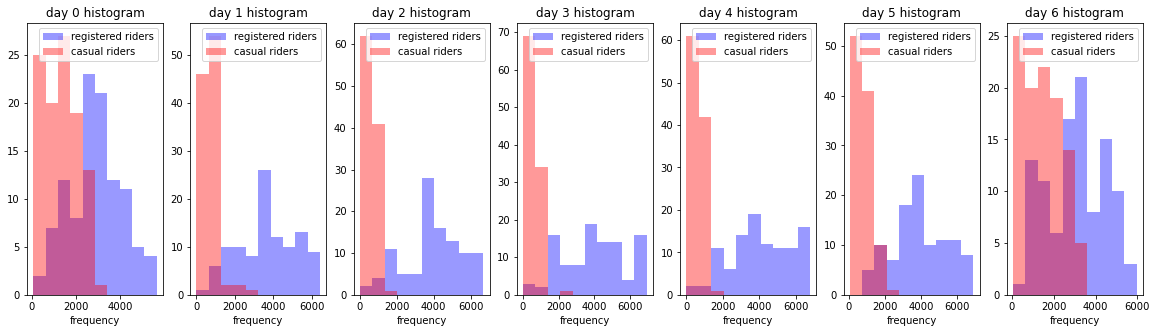

In [10]:
#plot showing distribution of registered and casual riders on each day of the week
fig, ax = plt.subplots(1,7, figsize = (20,5))
for day in range(0,7):
    #get the bin edges
    bins=np.histogram(np.hstack((bikes_by_day['registered'][bikes_by_day['weekday']==day],bikes_by_day['casual'][bikes_by_day['weekday']==day])), bins=10)[1]
    ax[day].hist(bikes_by_day['registered'][bikes_by_day['weekday']==day], alpha = 0.4, color = 'blue', label = 'registered riders', bins=bins)
    ax[day].hist(bikes_by_day['casual'][bikes_by_day['weekday']==day], alpha = 0.4, color = 'red', label = 'casual riders', bins=bins)
    ax[day].legend()
    ax[day].set_title('day {} histogram'.format(day))
    ax[day].set_xlabel('number of riders')
    ax[day].set_xlabel('frequency')
    
"""
DISTRIBUTION OF RIDES:
1. registered rides seem symmetrical, casual rides seem right skewed for the most part.
2. number of rides varies significantly by day (we can see this from the changing axis on each plot, from a max value of just above 20 on day 0,
to over 35 on day 1).
3. Number of casual riders is lower, on average, than number of registered riders. This is especially true on days 1-5, and still true (but to 
a lesser extent) on day 0 and day 6, when there are relatively more casual riders.
""";

**2.2** Use `bikes_by_day` (please use the copy provided to you in `data/bikes_by_day.csv` for consistency and easy checking) to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 

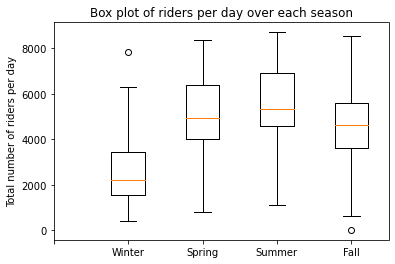

In [11]:
#loading from csv file
bikes_by_day = pd.read_csv("data/bikes_by_day.csv")

seasons = [1, 2, 3, 4]
plt.boxplot([bikes_by_day['counts'][bikes_by_day.season == s] for s in seasons])
xlabels = ['','Winter','Spring','Summer','Fall']
xpos = np.arange(len(xlabels))
plt.xticks(xpos, xlabels)
plt.ylabel('Total number of riders per day')
plt.title('Box plot of riders per day over each season');

plt.show()

Investigating outliers:
- Two outliers are visible - one in season 1 (a high value) and one in season 4 (an abnormally low value).
- First we investigate the value in season 1
    - To do this we use the .groupby() and then the max function to get the highest value for 'total' in each season. We see that this value is 7836 for season 1. Next we find the row where this value appears. This date is 2012-03-17. Looking up this value online we find that it is notable on two accounts. It is St Patrick's Day, and also it is a day when Barack Obama gave a speech in Washington DC to commemorate this day. This would explain the abnormally high level of bike usage on the day. This shows that the outlier is a legitimate value due to a significant event.
- Next we investigate the value in season 4
    - We use the same process as above. Looking up the date 2012-10-29 we see that this day was notable for Hurricane Sandy. This may explain the abnormally low usage if people are afraid of the weather.

In [12]:
max_value_winter = bikes_by_day.groupby(['season']).max()['counts'][1]

#finding row where max value appears
bikes_by_day[(bikes_by_day['counts'] == max_value_winter) & (bikes_by_day['season'] == 1)]

,dteday,counts,casual,weather,registered,season,weekday,windspeed,temp,atemp,hum,high_casual
441,2012-03-17,7836,3155,2,4681,1,6,0.110704,0.514167,0.505046,0.755833,1


In [13]:
min_value_spring = bikes_by_day.groupby(['season']).min()['counts'][4]

#finding row where min value appears
bikes_by_day[(bikes_by_day['counts'] == min_value_spring) & (bikes_by_day['season'] == 4)]

,dteday,counts,casual,weather,registered,season,weekday,windspeed,temp,atemp,hum,high_casual
667,2012-10-29,22,2,3,20,4,1,0.3582,0.44,0.4394,0.88,0


**2.3** Convert the categorical attributes ('season', 'month', 'weekday', 'weather') in the original hourly dataset into multiple binary attributes using **one-hot encoding** and call this new dataframe `bikes_df`.

In [14]:
bikes_df = pd.get_dummies(bikes_df_raw, columns=['season','weekday','month','weather'], drop_first=True)

# checking
bikes_df.columns

Index(['dteday', 'hour', 'holiday', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'casual', 'registered', 'year', 'counts', 'season_2',
       'season_3', 'season_4', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'weather_2', 'weather_3', 'weather_4'],
      dtype='object')

**2.4** Split the updated `bikes_df` dataset into a 50-50 train-test split (call them `bikes_train` and `bikes_test`, respectively). Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set.  Use `random_state=90`, a test set size of .5, and stratify on month.  Remember to specify the data's index column as you read it in.


In [15]:
train_data, test_data = train_test_split(
    bikes_df, 
    test_size = 0.5, 
    stratify = bikes_df[['month_2', 'month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12']], 
    random_state = 90
)

#QQ - what does it mean "remember to specify the data's index column as you read it in??

**2.5** Although we asked you to create your train and test set, for consistency, we ask that for the rest of this problem set you use the train and test set provided in the files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). 

In [16]:
BSS_train = pd.read_csv('data/BSS_train.csv')
BSS_test = pd.read_csv('data/BSS_test.csv')

BSS_train = BSS_train.drop(['dteday'], axis = 1)
BSS_test = BSS_test.drop(['dteday'], axis = 1)

BSS_train.head()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,casual,registered,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,21,0,1,1,0.24,0.2273,0.60,0.2537,12,51,...,1,0,0,0,1,0,0,1,0,0
1,17,0,0,1,0.62,0.5758,0.83,0.2537,47,432,...,0,0,0,0,1,0,0,0,1,0
2,9,0,1,1,0.76,0.7273,0.66,0.1642,54,299,...,0,0,0,0,1,0,0,0,0,0
3,17,0,1,0,0.62,0.6061,0.22,0.2985,185,226,...,0,0,0,0,0,0,0,0,0,0
4,8,0,1,0,0.18,0.1970,0.40,0.1343,9,61,...,0,0,0,0,0,0,0,0,0,0


**2.6** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe.

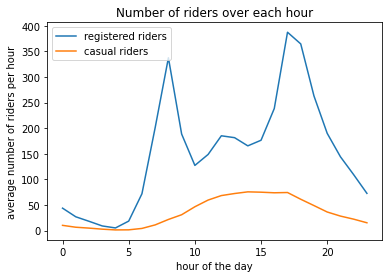

In [17]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

bikes_by_hour = bikes_df.copy()
bikes_by_hour = bikes_by_hour.groupby('hour').aggregate(
    {'casual' : np.mean,
     'registered' : np.mean}
)

plt.plot(bikes_by_hour['registered'])
plt.plot(bikes_by_hour['casual'])
ax.legend(["registered riders", "casual riders"])
ax.set_xlabel("hour of the day")
ax.set_ylabel("average number of riders per hour")
plt.title('Number of riders over each hour');
plt.show()

There are distinct trends for registered and casual riders. Registered riders have two peaks in the graph - one in the early morning and one in the late evening. These are likely related to getting to and from work. Casual riders, meanwhile, have just one (shallower) peak, which reaches a peak at 14 hours in the day. These are likely predominantly rides for pleasure/travel purposes since the peak is unrelated to work opening and closing times.



---

<div class='exercise'> <b> Question 3 [25pts]: Linear Regression to Model Hourly Ridership </b> </div>

**3.1** Use a linear regression model to formally test (via a probabilistic-based hypothesis test) whether `counts` is significantly different in the summer than the other months combined.  Be sure to interpret the results.  

**3.2** Use a resampling method to determine whether `counts` is significantly different in the summer than the other months combined.  How do these results compare to **3.1**?

**3.3** Use statsmodels to fit a multiple linear regression model to the training set using all the useable predictors (nothing that `count` was directly derived from and no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.  Call this set of predictors `X_train`.

**3.4** Examine the estimated coefficients and report which ones are statistically significant (at a significance level of $\alpha = 0.05$). 

**3.5** You should see some strange estimates for the predictors representing months.  Carefully interpret the `July` coefficient, and explain why this result is likely occurring (be as specific as possible). 

**3.6** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?


### Answers

**3.1** Use a linear regression model to formally test (via a probabilistic-based hypothesis test) whether `counts` is significantly different in the summer than the other months combined.  Be sure to interpret the results.  

In [18]:
X = sm.add_constant(BSS_train['summer'])

ols_model = sm.OLS(BSS_train['counts'], X).fit()

ols_model.summary()

/Users/anuragmitra/opt/miniconda3/envs/cs109a/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     192.2
Date:                Wed, 14 Jul 2021   Prob (F-statistic):           3.02e-43
Time:                        05:38:19   Log-Likelihood:                -57424.
No. Observations:                8689   AIC:                         1.149e+05
Df Residuals:                    8687   BIC:                         1.149e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        174.5887      2.237     78.044      0.000     170.204     178.974
summer        60.9071      4.393     13.864      0.000      52.295      69.519
==============================================================================
Omnibus:                     1616.728   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2773.202
Skew:                           1.220   Prob(JB):                         0.00
Kurtosis:                       4.305   Cond. No.                         2.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We want to difference between the counts in the summer and other seasons by using a t-test.

The null hypthesis ($H_0$) is that the true difference between the means of the counts in summer vs the other seasons combined is zero.\
The alternate hypothesis ($H_1$) is that the true difference is different from zero.

The $t$-value is $13.864$, which means that the coefficient is $13.864 \sigma$s away from 0. The $p$-value is nearly $0$ which means that the chance of this beta coefficient occuring by chance when the null hypothesis is true is nearly $0$ (which is less than $0.05$).

Hence we have sufficient evidence to REJECT the null hypothesis that the coefficient is 0.

**3.2** Use a resampling method to determine whether `counts` is significantly different in the summer than the other months combined.  How do these results compare to **3.1**?

In [19]:
regress1 = LinearRegression(fit_intercept=True).fit(BSS_train[['summer']], BSS_train['counts'])
print("Observed beta1 =", regress1.coef_)

Observed beta1 = [60.9070637]


Empirical estimate of the p-value based on 1000 iterations is: 0.0
empirical 95% confidence interval is [-7.287853299391962, 6.969324337800242]


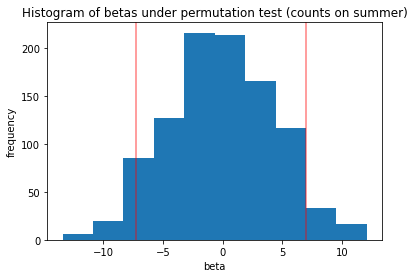

In [20]:
nperms = 1000
nboots = 1000
n = np.size(BSS_train['counts'])
beta1_perms = []

# use a for loop to do the reampling for us
for boot in np.arange(nboots):
    y_perm = np.random.choice(BSS_train['counts'],size=n,replace=False)
    regress_perm = LinearRegression(fit_intercept=True).fit(BSS_train[['summer']], y_perm)

    beta1_perms.append(regress_perm.coef_[0])

plt.hist(beta1_perms)

five_pc_ci = np.percentile(beta1_perms, [5,95])[0]
ninetyfive_pc_ci = np.percentile(beta1_perms, [5,95])[1]

plt.axvline(five_pc_ci, color = 'red', alpha = .5)
plt.axvline(ninetyfive_pc_ci, color = 'red', alpha = .5)
plt.xlabel('beta')
plt.ylabel('frequency')
plt.title('Histogram of betas under permutation test (counts on summer)')

print("Empirical estimate of the p-value based on 1000 iterations is:" , 
      np.mean(np.abs(beta1_perms)>np.abs(regress1.coef_[0])))

print('empirical 95% confidence interval is [{}, {}]'.format(five_pc_ci, ninetyfive_pc_ci))

This is a permutation test. This calculates the distribution of beta_1 in the situation that there is really no relationship between summer and counts. In this case we see via the histogram that beta would likely be within the range of [-7.52, 7.86], as this is the 95% confidence interval of the coefficient. The fact that we have a coefficient that is greater than 60 provides evidence at the 5% level that the relationship between summer and counts is not a chance relationship, since this value is outside the empirical confidence interval that we have calculated for $\beta$ via the permutation test.

As with 3.1, this means we have sufficient evidence to reject the null hypothesis that the coefficient is zero.

**3.3** Use statsmodels to fit a multiple linear regression model to the training set using all the useable predictors (nothing that `count` was directly derived from and no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.  Call this set of predictors `X_train`.

In [21]:
trivial_cols = ['casual','registered']
BSS_train = BSS_train.drop(trivial_cols, axis=1)
BSS_test = BSS_test.drop(trivial_cols, axis=1)

X = sm.add_constant(BSS_train.drop(['counts'], axis = 1))

regress_mult = sm.OLS(BSS_train['counts'], X).fit()

regress_mult.summary()

/Users/anuragmitra/opt/miniconda3/envs/cs109a/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     201.9
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        05:38:23   Log-Likelihood:                -55215.
No. Observations:                8689   AIC:                         1.105e+05
Df Residuals:                    8658   BIC:                         1.107e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -30.4075     10.908     -2.788      0.005     -51.789      -9.026
hour           7.2092      0.233     30.975      0.000       6.753       7.665
holiday      -19.1510      8.369     -2.288      0.022     -35.556      -2.746
year          78.1211      3.020     25.864      0.000      72.200      84.042
workingday    10.9484      3.512      3.118      0.002       4.065      17.832
temp         273.6625     61.680      4.437      0.000     152.755     394.570
atemp        162.5353     64.909      2.504      0.012      35.298     289.773
hum         -202.0080      9.927    -20.349      0.000    -221.468    -182.548
windspeed     19.3827     13.595      1.426      0.154      -7.268      46.033
spring        50.0754      9.528      5.256      0.000      31.398      68.753
summer        22.6879     11.138      2.037      0.042       0.855      44.521
fall          70.9474      9.448      7.509      0.000      52.426      89.469
Feb          -10.7198      7.590     -1.412      0.158     -25.598       4.158
Mar          -11.2938      8.385     -1.347      0.178     -27.731       5.143
Apr          -44.8326     12.635     -3.548      0.000     -69.600     -20.065
May          -50.1605     13.493     -3.718      0.000     -76.609     -23.712
Jun          -72.2042     13.700     -5.271      0.000     -99.058     -45.350
Jul          -90.8965     15.387     -5.907      0.000    -121.058     -60.735
Aug          -58.3246     15.061     -3.873      0.000     -87.847     -28.802
Sept         -16.1686     13.432     -1.204      0.229     -42.499      10.162
Oct          -15.8838     12.484     -1.272      0.203     -40.356       8.588
Nov          -32.7232     12.049     -2.716      0.007     -56.342      -9.104
Dec          -19.2088      9.560     -2.009      0.045     -37.949      -0.469
Mon           -3.3336      3.756     -0.888      0.375     -10.697       4.029
Tue           -0.0074      4.105     -0.002      0.999      -8.055       8.040
Wed           -2.2059      4.082     -0.540      0.589     -10.207       5.795
Thu           -5.5698      4.013     -1.388      0.165     -13.436       2.297
Fri            2.9140      4.015      0.726      0.468      -4.956      10.784
Sat           12.7461      5.587      2.281      0.023       1.793      23.699
Cloudy         6.9163      3.676      1.882      0.060      -0.289      14.122
Snow         -26.8155      6.094     -4.401      0.000     -38.760     -14.871
Storm         48.2045     98.839      0.488      0.626    -145.543     241.952
==============================================================================
Omnibus:                     1691.839   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3250.657
Skew:                           1.191   Prob(JB):                         0.00
Ku

In [22]:
inpt_train = BSS_train.drop(['counts'], axis = 1)
inpt_test = BSS_test.drop(['counts'], axis = 1)

print(r2_score(BSS_train['counts'], regress_mult.predict(sm.add_constant(inpt_train))))
print(r2_score(BSS_test['counts'], regress_mult.predict(sm.add_constant(inpt_test))))
#slightly lower score on training than test set. Shows small degree of overfitting

0.4115699822629326
0.40072109229413466


/Users/anuragmitra/opt/miniconda3/envs/cs109a/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/anuragmitra/opt/miniconda3/envs/cs109a/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [23]:
#defining X_train
X_train = BSS_train.drop(['counts'], axis = 1).copy()

In [24]:
X_train.columns

Index(['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr', 'May',
       'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed',
       'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm'],
      dtype='object')

**3.4** Examine the estimated coefficients and report which ones are statistically significant (at a significance level of $\alpha = 0.05$). 

The significant predictors at a 5% level (values where the P-values < alpha) are: 

[`hour`, `year`, `workingday`, `temp`, `hum`, `spring`, `fall`, `Apr`, `May`, `Jun`, `Jul`, `Aug`, `Snow`].
Quite a few of the predictors are significant!

**3.5** You should see some strange estimates for the predictors representing months.  Carefully interpret the `July` coefficient, and explain why this result is likely occurring (be as specific as possible). 

The July coefficient is -90.8965. The interpretation of this is that in July, on average and holding all other variables constant, 90.8965 fewer people use bikes compared to the all the other months in the year. This is a little surprising because you'd think more people would go out in July when the weather is warm compared to the rest of the months. 

This can be explained by looking at some of the other variables. For example, humidity has a very high negative coefficient and thus the rise in humidity in July could cause the decrease in the number of riders.

July can also see a drop in the windspeeds without any seasonal winds at that time which can further contribute to the low number of people biking in July.

**3.6** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

/Users/anuragmitra/opt/miniconda3/envs/cs109a/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


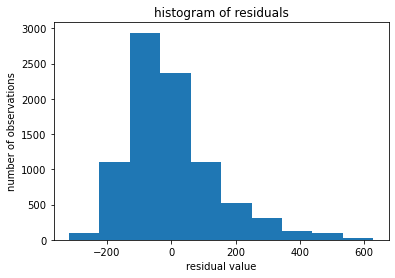

In [25]:
#plotting a histogram of the residuals
residuals_list = BSS_train['counts'] - regress_mult.predict(sm.add_constant(X_train))
plt.hist(residuals_list)
plt.ylabel("number of observations")
plt.xlabel("residual value")
plt.title("histogram of residuals")
plt.show()

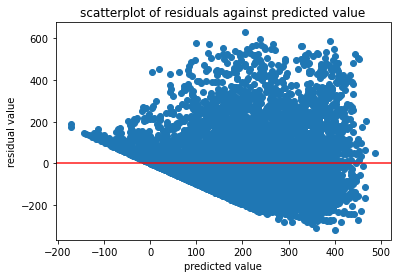

In [26]:
predicted_val_list = regress_mult.predict(sm.add_constant(X_train))
plt.scatter(predicted_val_list, residuals_list)
plt.ylabel("residual value")
plt.xlabel("predicted value")
plt.title("scatterplot of residuals against predicted value")
plt.axhline(0, color = 'red', alpha = .9)
plt.show()

- Normality: The histogram appears slightly right skewed, but overall the normality assumption does not seem implausible. 
- Linearity: It can be seen easily that there exists non-linearity in the dat. This is illustrated in the second graph where the residuals don't follow a linear path along the horizontal line through $y=0$.
- Constant variance: Not satisfied. The variance of the residuals increases with predicted value. So the constant variance of residuals is not satisfied.

---

<div class='exercise'> <b> Question 4 [22pts]: Regression Models with Polynomial and Interaction Terms </b> </div>

**4.1** Drop the variables `workingday`, `atemp`, `spring`, `summer`, `fall`, and  `dteday` from `BSS_train` and `BSS_test` (if any of them still remain) to reduce the collinearity in the predictor space.  The variables that remain should be: 

`['hour', 'holiday', 'year', 'temp', 'hum', 'windspeed', 'counts', 'Feb',
  'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec',
  'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm']`

**4.2** Write a function to standardize a provided subset of columns in your training/validation/test sets. Remember that while you will be scaling all of your data, you must learn the scaling parameters (mean and SD) from only the training set.

Test your code by building a list of all non-binary columns from `X_train` into a dataset called `practice_X_train` and scaling only those columns. Call the result `practice_X_train_scaled`. Display the `.describe()` and verify that you have correctly scaled all columns.

**Hint: employ the provided list of binary columns and use `pd.columns.difference()`**

`binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']`


**4.3** Write a code to augment your a dataset with higher-order features for `temp`, `hum`,`windspeed`, and `hour`. You should include ONLY the pure powers of these columns. So with `degree=2` you should produce `temp^2` and `hum^2` but not `temp*hum` or any other two-feature interactions. 

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by producing `practice_X_train_poly`, a training dataset with quadratic and cubic features built from `practice_X_train_scaled`, and printing `practice_X_train_poly`'s column names and `.head()`.

**4.4** Write code to add interaction terms to the model. Specifically, we want interactions between the numeric predictors (`temp`, `hum`,`windspeed`) and the month and weekday dummies (`Feb`, `Mar`...`Dec`, `Mon`, `Tue`, ... `Sat`). That means you SHOULD build `temp*Feb` and `hum*Mon` and so on, but NOT `Feb*Mar` and NOT `Feb*Tue`. The interaction terms should always be a continuous feature times a month dummy or a numeric feature times a month of weekday dummy.

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by adding interaction terms to `practice_X_train_poly` and show its column names and `.head()`**

**4.5** Combine all your code so far into a function named `get_design_mats` that takes in `BSS_train`, `BSS_test`, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices `X_train` and `X_test` and responses `y_train` and `y_test`. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.


**4.6** For polynomials of `degrees = [3,6,9,12,15,18]`:

1.  Build the training design matrix and validation design matrix using the function `get_design_mats` with polynomial terms up through the specified degree.

2.  Fit a regression model to the training data.

3.  Report the model's score on the test data.

**4.7** Which model would you select, and why?

### Answers

**4.1 Drop...**

In [27]:
BSS_train = BSS_train.drop(['workingday', 'atemp', 'spring', 'summer', 'fall'], axis=1)
BSS_test = BSS_test.drop(['workingday', 'atemp', 'spring', 'summer', 'fall'], axis=1)

BSS_train.columns

Index(['hour', 'holiday', 'year', 'temp', 'hum', 'windspeed', 'counts', 'Feb',
       'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec',
       'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm'],
      dtype='object')

In [28]:
# checking
BSS_train.columns

Index(['hour', 'holiday', 'year', 'temp', 'hum', 'windspeed', 'counts', 'Feb',
       'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec',
       'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm'],
      dtype='object')

**4.2 Write a function to standardize...**


In [29]:
def scale_datasets(train_data, test_data, cols_to_scale):
    """
    This function will be used to standardize columns in your datasets. It
    also allows you to pass in a test dataset, which will be standardized
    using the stats from the training data. 
    
    :param: train: The training dataset
    :param: test: The test dataset, which will be standardized using stats 
                  from the training data. 
    :param: cols_to_scale: List containing the column names to be standardized
    :return: (DataFrame, DataFrame) Standardized test and training DataFrames
    """
    train = train_data.copy()
    test = test_data.copy()
    
    for col in cols_to_scale:
        mean = train[col].mean()
        std = train[col].std()
        train[col] = (train[col] - mean) / std
        test[col] = (test[col] - mean) / std
        
    return train, test

In [30]:
def split_columns(df, target_col, drop_columns):
    """
    :param: df: Your DataFrame
    :param: target_col: The name of the response variable
    :param: drop_columns: List containing the column names you want to drop
    :return: (X_train, y_train)
    """
    X_train = df.copy()
    for col in drop_columns:
        del X_train[col]
        
    y_train = df[target_col]
    return X_train, y_train


In [31]:
binary_columns = [
    'holiday', 'workingday','Feb', 'Mar', 'Apr',
    'May', 'Jun', 'Jul', 'Aug', 'Sept', 
    'Oct', 'Nov', 'Dec', 'spring', 'summer', 
    'fall', 'Mon', 'Tue', 'Wed', 'Thu', 
    'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm'
]
non_binary_columns = BSS_train.columns.difference(binary_columns)

In [32]:
practice_X_train = BSS_train[non_binary_columns]
practice_X_test = BSS_test[non_binary_columns]

practice_X_train_scaled, practice_X_test_scaled = scale_datasets(practice_X_train, practice_X_test, non_binary_columns)
practice_X_train_scaled.describe()

,counts,hour,hum,temp,windspeed,year
count,8.689000e+03,8.689000e+03,8.689000e+03,8.689000e+03,8.689000e+03,8.689000e+03
mean,6.602051e-17,7.326526e-17,3.874411e-14,1.180187e-14,7.452489e-14,1.077015e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.043814e+00,-1.666263e+00,-3.251787e+00,-2.474050e+00,-1.546547e+00,-1.006755e+00
25%,-8.288580e-01,-8.042200e-01,-7.554373e-01,-8.122357e-01,-6.986934e-01,-1.006755e+00
50%,-2.556411e-01,5.782341e-02,-2.733539e-02,1.867126e-02,2.745877e-02,9.931755e-01
75%,5.159971e-01,9.198668e-01,8.047811e-01,8.495782e-01,5.118307e-01,9.931755e-01
max,4.335606e+00,1.638236e+00,1.948941e+00,2.511392e+00,5.355550e+00,9.931755e-01


**4.3 Write code to augment your a dataset with higher-order features for...**

In [33]:
def add_poly_features(dataset, degree, columns):
    """
    :param dataset: Your data
    :param degree: Max degree
    :return: Augmented DataFrame
    """
    poly_dataset = dataset.copy()
    
    for column in columns:
        for i in range(degree+1):
            if i == 0 or i == 1:
                continue
            column_name = column + "^" + str(i)
            poly_dataset[column_name] = dataset[column] ** i
    
    return poly_dataset

In [34]:
# testing the function
practice_X_train_poly = add_poly_features(practice_X_train_scaled, 3, ['temp', 'hum', 'windspeed', 'hour'])
practice_X_train_poly.columns

Index(['counts', 'hour', 'hum', 'temp', 'windspeed', 'year', 'temp^2',
       'temp^3', 'hum^2', 'hum^3', 'windspeed^2', 'windspeed^3', 'hour^2',
       'hour^3'],
      dtype='object')

In [35]:
practice_X_train_poly.head()

,counts,hour,hum,temp,windspeed,year,temp^2,temp^3,hum^2,hum^3,windspeed^2,windspeed^3,hour^2,hour^3
0,-0.702089,1.350889,-0.131350,-1.331553,0.511831,0.993176,1.773032,-2.360885,0.017253,-0.002266,0.261971,0.134085,1.824900,2.465236
1,1.590779,0.776193,1.064817,0.641851,0.511831,-1.006755,0.411973,0.264426,1.133836,1.207329,0.261971,0.134085,0.602475,0.467637
2,0.896304,-0.373198,0.180694,1.368895,-0.214322,0.993176,1.873874,2.565136,0.032650,0.005900,0.045934,-0.009845,0.139277,-0.051978
3,1.215983,0.776193,-2.107627,0.641851,0.875312,0.993176,0.411973,0.264426,4.442090,-9.362266,0.766172,0.670640,0.602475,0.467637
4,-0.663507,-0.516872,-1.171496,-1.643143,-0.456913,0.993176,2.699918,-4.436350,1.372402,-1.607762,0.208770,-0.095390,0.267157,-0.138086


In [36]:
practice_X_train_poly.shape

(8689, 14)

**4.4 Write code to add interaction terms to the model...**

In [37]:
def build_interaction(df, interact_left, interact_right):
    """
    :param df: Your data
    :param interact_left: The first set of columns you want to use in interactions
    :param interact_right: The set of columns you want to generate interactions terms
                           with in interact_left
    """
    result_df = df.copy()
    for column_1 in interact_left:
        for column_2 in interact_right:
            column_name = column_1+"*"+column_2 
            result_df[column_name] = result_df[column_1] * result_df[column_2]

    return result_df

In [38]:
month_weekday_dummies = ['Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
practice_X_train_poly[month_weekday_dummies] = BSS_train[month_weekday_dummies]

practice_X_train_poly_interactions = build_interaction(
    practice_X_train_poly, 
    ['temp', 'hour','hum','windspeed'], month_weekday_dummies
)
for i in practice_X_train_poly_interactions.columns:
    print(i)
practice_X_train_poly_interactions.head()


counts
hour
hum
temp
windspeed
year
temp^2
temp^3
hum^2
hum^3
windspeed^2
windspeed^3
hour^2
hour^3
Feb
Mar
Apr
May
Jun
Jul
Aug
Sept
Oct
Nov
Dec
Mon
Tue
Wed
Thu
Fri
Sat
temp*Feb
temp*Mar
temp*Apr
temp*May
temp*Jun
temp*Jul
temp*Aug
temp*Sept
temp*Oct
temp*Nov
temp*Dec
temp*Mon
temp*Tue
temp*Wed
temp*Thu
temp*Fri
temp*Sat
hour*Feb
hour*Mar
hour*Apr
hour*May
hour*Jun
hour*Jul
hour*Aug
hour*Sept
hour*Oct
hour*Nov
hour*Dec
hour*Mon
hour*Tue
hour*Wed
hour*Thu
hour*Fri
hour*Sat
hum*Feb
hum*Mar
hum*Apr
hum*May
hum*Jun
hum*Jul
hum*Aug
hum*Sept
hum*Oct
hum*Nov
hum*Dec
hum*Mon
hum*Tue
hum*Wed
hum*Thu
hum*Fri
hum*Sat
windspeed*Feb
windspeed*Mar
windspeed*Apr
windspeed*May
windspeed*Jun
windspeed*Jul
windspeed*Aug
windspeed*Sept
windspeed*Oct
windspeed*Nov
windspeed*Dec
windspeed*Mon
windspeed*Tue
windspeed*Wed
windspeed*Thu
windspeed*Fri
windspeed*Sat


,counts,hour,hum,temp,windspeed,year,temp^2,temp^3,hum^2,hum^3,...,windspeed*Sept,windspeed*Oct,windspeed*Nov,windspeed*Dec,windspeed*Mon,windspeed*Tue,windspeed*Wed,windspeed*Thu,windspeed*Fri,windspeed*Sat
0,-0.702089,1.350889,-0.131350,-1.331553,0.511831,0.993176,1.773032,-2.360885,0.017253,-0.002266,...,0.0,0.000000,0.0,0.511831,0.0,0.0,0.0,0.511831,0.0,0.0
1,1.590779,0.776193,1.064817,0.641851,0.511831,-1.006755,0.411973,0.264426,1.133836,1.207329,...,0.0,0.511831,0.0,0.000000,0.0,0.0,0.0,0.511831,0.0,0.0
2,0.896304,-0.373198,0.180694,1.368895,-0.214322,0.993176,1.873874,2.565136,0.032650,0.005900,...,-0.0,-0.000000,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.214322,-0.0,-0.0
3,1.215983,0.776193,-2.107627,0.641851,0.875312,0.993176,0.411973,0.264426,4.442090,-9.362266,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
4,-0.663507,-0.516872,-1.171496,-1.643143,-0.456913,0.993176,2.699918,-4.436350,1.372402,-1.607762,...,-0.0,-0.000000,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0


In [39]:
practice_X_train_poly_interactions.describe()

,counts,hour,hum,temp,windspeed,year,temp^2,temp^3,hum^2,hum^3,...,windspeed*Sept,windspeed*Oct,windspeed*Nov,windspeed*Dec,windspeed*Mon,windspeed*Tue,windspeed*Wed,windspeed*Thu,windspeed*Fri,windspeed*Sat
count,8.689000e+03,8.689000e+03,8.689000e+03,8.689000e+03,8.689000e+03,8.689000e+03,8689.000000,8689.000000,8689.000000,8689.000000,...,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000
mean,6.602051e-17,7.326526e-17,3.874411e-14,1.180187e-14,7.452489e-14,1.077015e-15,0.999885,-0.003552,0.999885,-0.117150,...,-0.018334,-0.013420,-0.004616,-0.007543,-0.001365,0.004269,-0.003621,0.001751,-0.002836,0.005889
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.031393,2.427325,1.096709,2.722721,...,0.266038,0.301259,0.287817,0.302338,0.386071,0.371281,0.380900,0.363119,0.391164,0.384242
min,-1.043814e+00,-1.666263e+00,-3.251787e+00,-2.474050e+00,-1.546547e+00,-1.006755e+00,0.000349,-15.143462,0.000609,-34.384770,...,-1.546547,-1.546547,-1.546547,-1.546547,-1.546547,-1.546547,-1.546547,-1.546547,-1.546547,-1.546547
25%,-8.288580e-01,-8.042200e-01,-7.554373e-01,-8.122357e-01,-6.986934e-01,-1.006755e+00,0.188464,-0.535854,0.153183,-0.431117,...,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-2.556411e-01,5.782341e-02,-2.733539e-02,1.867126e-02,2.745877e-02,9.931755e-01,0.659727,0.000007,0.647673,-0.000020,...,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000
75%,5.159971e-01,9.198668e-01,8.047811e-01,8.495782e-01,5.118307e-01,9.931755e-01,1.507221,0.613211,1.620138,0.521235,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.335606e+00,1.638236e+00,1.948941e+00,2.511392e+00,5.355550e+00,9.931755e-01,6.307090,15.839576,10.574116,7.402803,...,3.660654,3.176282,3.418062,3.781544,4.265916,4.750288,3.660654,3.660654,4.992879,5.234659


**4.5** Combine all your code so far into a function named `get_design_mats` that takes in `BSS_train`, `BSS_test`, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices `X_train` and `X_test` and responses `y_train` and `y_test`. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.

In [40]:
print(BSS_train.shape)
print(BSS_test.shape)

(8689, 27)
(8690, 27)


In [41]:
def get_design_mats(train_df, val_df,  degree, 
                    columns_forpoly=['temp', 'hum','windspeed', 'hour'],
                    target_col='counts', 
                    bad_columns=['counts']):
    """
    :param train_df: The training data
    :param val_df: Your test/validation data
    :param columns_forpoly: List containing the column name for which we want to create 
                            polynomial terms
    :param target_col: The response variable column
    :param bad_columns: The columns you want to drop
    """
    
    X_train = train_df.copy()
    X_test = val_df.copy()
    
    #scale non-binary columns that are in the dataframe
    #QQ - may need to NOT scale some cols here
    X_train, X_test = scale_datasets(X_train, X_test, ['temp', 'hum', 'windspeed', 'hour', 'year'])
    
    #create responses
    y_train = X_train[target_col]
    y_test = X_test[target_col]
    
    #drop bad columns
    X_train = X_train.drop(bad_columns, axis = 1)
    X_test = X_test.drop(bad_columns, axis = 1)
    
    #polynomial degrees
    X_train = add_poly_features(X_train, degree, columns_forpoly)
    X_test = add_poly_features(X_test, degree, columns_forpoly)
    
    #interaction terms
    interact_continuous = ['temp', 'hum', 'windspeed', 'hour']
    interact_discrete = ['Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 
     'Aug', 'Sept', 'Oct', 'Nov', 'Dec',
     'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
    
    X_train = build_interaction(X_train, interact_continuous, interact_discrete)
    X_test = build_interaction(X_test, interact_continuous, interact_discrete)
    
     
    return X_train, y_train, X_test, y_test

**4.6 For polynomials of `degrees = [3,6,9,12,15,18]`:...**

In [42]:
degrees = [3,6,9,12,15,18]

for degree in degrees:
    #getting train and test datasets
    X_train, y_train, X_test, y_test = get_design_mats(BSS_train, BSS_test, degree)
    #print(X_train.head())
    #fitting a regression model to the training data
    regress = LinearRegression(fit_intercept=True).fit(X_train, y_train)
    print('degree {} model score is {} on TEST data'.format(degree, regress.score(X_test, y_test)))


degree 3 model score is 0.5724879174547226 on TEST data
degree 6 model score is 0.609356553103693 on TEST data
degree 9 model score is 0.6601476836166149 on TEST data
degree 12 model score is 0.6653164752465033 on TEST data
degree 15 model score is 0.6980353784365377 on TEST data
degree 18 model score is 0.6844056493354564 on TEST data


**4.7 Which model would you select, and why?**

I would select the degree 15 model since it has the highest $R^2$. However, it is important to note that we could have just been lucky here. To have a better idea of what model is best we should cross-validate.


---

<div class='exercise'> <b> Question 5 [25pts]: Regularized Models </b> </div>

**5.1** Let's try regularizing our models via ridge regression. Split the training set, `BSS_train`, into an 80-20 train-validation split (use `random_state=109`).  Build a table showing the validation set $R^2$ for the degree-15 polynomial model, regularized at the levels `alphas = np.exp(np.arange(-10,11,1))`. Do not perform cross validation at this point, simply report performance on the single validation set. 

**5.2** Find the best-scoring Ridge model above.

**5.3** It's time to see how well our selected model will do on future data. Use the earlier created test dataset, do any required formatting, and report the best model's $R^2$ score. How does it compare to the validation set score that made us choose this model? Does the test set simply have observations that are more difficult or easier to predict?

**5.4** Build a dataset (design matrix) with polynomial degree 2 and fit an OLS model, a Ridge model, and a Lasso model. Use `RidgeCV` and `LassoCV` to select the best regularization level from among `alphas = np.exp(np.arange(-10,10,1))`. 

Note: On the lasso model, you may need to increase `max_iter` (start with 100,000) for the optimization to converge.

**5.5** Build a plot which cleanly presents, for the 'main effect' features: 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso, so that each predictor's coefficient can be easily compared across the 3 models.  These main effect features should be: `['hour', 'holiday', 'year', 'temp', 'hum', 'windspeed', 'Feb', 'Mar',
       'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon',
       'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm']`

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

**5.6** What differences do you see in the plot above comparing the 3 types of models?  Are any of the results surprising?

### Answers

**5.1** Let's try regularizing our models via ridge regression. Split the training set, `BSS_train`, into an 80-20 train-validation split (use `random_state=109`).  Build a table showing the validation set $R^2$ for the degree-15 polynomial model, regularized at the levels `alphas = np.exp(np.arange(-10,11,1))`. Do not perform cross validation at this point, simply report performance on the single validation set. 

In [43]:
bikes_train, bikes_val = train_test_split(BSS_train, test_size=.2, random_state=109)

In [44]:
print(bikes_train.shape)
print(bikes_val.shape)

(6951, 27)
(1738, 27)


/Users/anuragmitra/opt/miniconda3/envs/cs109a/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.91681e-26): result may not be accurate.
  overwrite_a=True).T
/Users/anuragmitra/opt/miniconda3/envs/cs109a/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.71554e-26): result may not be accurate.
  overwrite_a=True).T
/Users/anuragmitra/opt/miniconda3/envs/cs109a/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.18995e-25): result may not be accurate.
  overwrite_a=True).T
/Users/anuragmitra/opt/miniconda3/envs/cs109a/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.79164e-25): result may not be accurate.
  overwrite_a=True).T
/Users/anuragmitra/opt/miniconda3/envs/cs109a/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning:

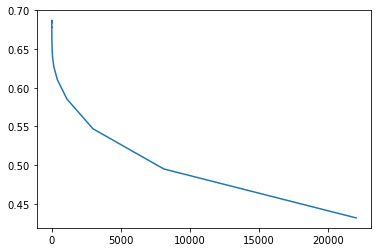

In [45]:
alphas = np.exp(np.arange(-10,11,1))

r_lst = []

X_train, y_train, X_val, y_val = get_design_mats(bikes_train, bikes_val, 15)

for c in alphas:    
    #fitting a regression model to the training data
    ridge = Ridge(alpha = c, fit_intercept=True).fit(X_train, y_train)
    r_lst.append(r2_score(y_val, ridge.predict(X_val)))

plt.plot(alphas, r_lst)

r2_dict = {
    'alpha': alphas,
    'r^2': r_lst
}

In [46]:
pd.DataFrame.from_dict(r2_dict)

,alpha,r^2
0,0.000045,0.684937
1,0.000123,0.683667
2,0.000335,0.687260
3,0.000912,0.686682
4,0.002479,0.682584
5,0.006738,0.680013
6,0.018316,0.678004
7,0.049787,0.678446
8,0.135335,0.676892
9,0.367879,0.676018


**5.2** Find the best-scoring Ridge model above.

In [47]:
best_alpha = alphas[r_lst.index(max(r_lst))]
print('The best alpha is {}'.format(best_alpha))

The best alpha is 0.00033546262790251185


**5.3** It's time to see how well our selected model will do on future data. Use the earlier created test dataset, do any required formatting, and report the best model's $R^2$ score. How does it compare to the validation set score that made us choose this model? Does the test set simply have observations that are more difficult or easier to predict?

In [48]:
best_ridge = Ridge(alpha = best_alpha, fit_intercept=True).fit(X_train, y_train)

_, _, X_test, y_test = get_design_mats(bikes_train, BSS_test, 15)

r2_score(y_test, ridge.predict(X_test))

/Users/anuragmitra/opt/miniconda3/envs/cs109a/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.18995e-25): result may not be accurate.
  overwrite_a=True).T


0.40699852877284803

The performance is significantly worse than on the validation set. This is likely because we did not perform cross-validation, and so overfitted to the validation set when choosing the order for our selected model. It isn't really a question of whether the test set has easier or harder observations, just that it is unknown and an overfit model can't perform well.

**5.4** Build a dataset (design matrix) with polynomial degree 2 and fit an OLS model, a Ridge model, and a Lasso model. Use `RidgeCV` and `LassoCV` to select the best regularization level from among `alphas = np.exp(np.arange(-10,10,1))`. 

Note: On the lasso model, you may need to increase `max_iter` (start with 100,000) for the optimization to converge.

In [49]:
#build dataset with polynomial degree 2
X_train, y_train, X_test, y_test = get_design_mats(BSS_train, BSS_test, 2)

alphas = np.exp(np.arange(-10,10,1))

lin_regress = LinearRegression(fit_intercept = True).fit(X_train, y_train)

ridges = RidgeCV(alphas = alphas, cv=10).fit(X_train, y_train)

lassos = LassoCV(alphas = alphas, cv=10, max_iter = 1000000).fit(X_train, y_train)

print("Linear regression (unregularized) score is", lin_regress.score(X_test, y_test))
print("RidgeCV score is", ridges.score(X_test, y_test))
print("LassoCV score is", lassos.score(X_test, y_test))

Linear regression (unregularized) score is 0.5225190487288567
RidgeCV score is 0.5224259291158168
LassoCV score is 0.5222787049344659


**5.5** Build a plot which cleanly presents, for the 'main effect' features: 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso, so that each predictor's coefficient can be easily compared across the 3 models.  These main effect features should be: `['hour', 'holiday', 'year', 'temp', 'hum', 'windspeed', 'Feb', 'Mar',
       'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon',
       'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm']`

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

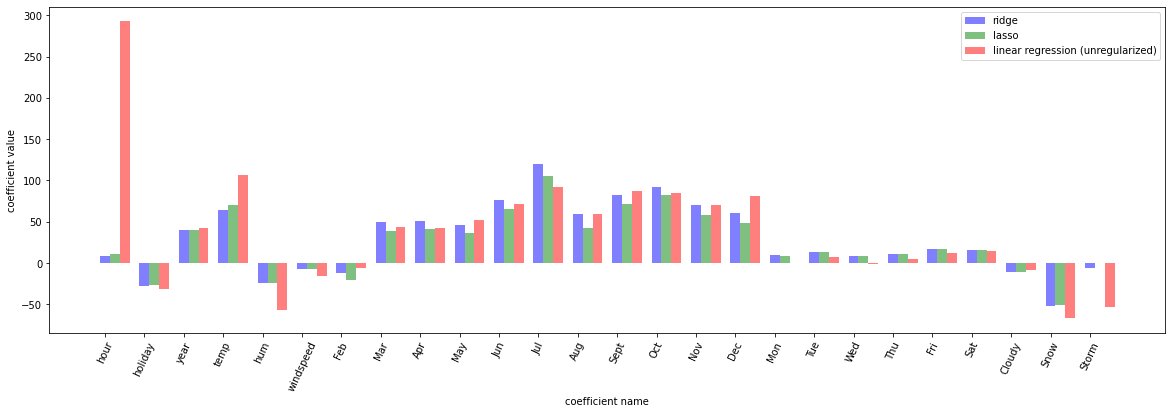

In [51]:
"""
print("RIDGE CV:Best model searched:\nalpha = {}\nintercept = {}\nbetas = {}, ".format(ridgeCV_object.alpha_,
                                                                            ridgeCV_object.intercept_,
                                                                            ridgeCV_object.coef_
                                                                            ))

print("LASSO CV:Best model searched:\nalpha = {}\nintercept = {}\nbetas = {}, ".format(lassoCV_object.alpha_,
                                                                            ridgeCV_object.intercept_,
                                                                            ridgeCV_object.coef_
                                                                            ))
"""


col_names = ['hour', 'holiday', 'year', 'temp', 'hum', 'windspeed', 'Feb', 'Mar',
       'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon',
       'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm']

data = [ridges.coef_[0:26], lassos.coef_[0:26], regress.coef_[0:26]]

fig, ax = plt.subplots(figsize = (20,6))

ax.set_xticks(np.asarray([i for i in range(26)]))
ax.set_xticklabels(col_names, rotation=65)

plt.bar(np.asarray([i for i in range(26)]) + 0.00, data[0], color = 'b', width = 0.25, label = "ridge", alpha = .5)
plt.bar(np.asarray([i for i in range(26)]) + 0.25, data[1], color = 'g', width = 0.25, label = "lasso",  alpha = .5)
plt.bar(np.asarray([i for i in range(26)]) + 0.50, data[2], color = 'r', width = 0.25, label = "linear regression (unregularized)",  alpha = .5)
plt.legend()
ax.set_ylabel('coefficient value')
ax.set_xlabel('coefficient name')
plt.show();


**5.6** What differences do you see in the plot above comparing the 3 types of models?  Are any of the results surprising?

One surprise is the paucity of columns for which lasso has completely eliminated the coefficient (only one (Storm) can be seen on the graph). 

Another surprising result is that in quite a few cases ridge and lasso actually increase the size of the coefficient, rather than reducing it (e.g. June, July, October, Friday, Saturday, Thursday). This still makes sense because maybe the variables confound with other variables thus resulting in some coefficients to rise with the fall of others.

---